#### 01_Pre-Treatment_Exploration_+_Causal_Design


# ------------------------------------------------------------
### **Business Q: What can the business do to decrease cancellations?**
### NOTE: This is pre-treatment exploratory + a baseline predictive model.


In [1]:
!pip install pytimetk --quiet
!pip install -U kaleido --quiet

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import pytimetk as tk
from missingno import matrix
import matplotlib.pyplot as plt
import missingno as msno
import kaleido

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.metrics import roc_auc_score

from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, average_precision_score

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/"
DATA_DIR = os.path.join(BASE_DIR, "data")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
CSV_PATH = os.path.join(BASE_DIR, "data/hotel_booking.csv")
# data exploration
hotel_cancellations_raw_df = pd.read_csv(CSV_PATH)

hotel_cancellations_raw_df.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734


In [5]:
hotel_cancellations_raw_df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000



# **COST ANALYSIS (business stakes)**

### Goal: **How many people cancel**, and what's the rough revenue at risk?
Notes:
- Use ADR - average daily rate (clip negatives to 0) * nights to estimate value per booking.
- Nights = stays_in_weekend_nights + stays_in_week_nights (raw columns).


In [6]:
cancellation_counts = hotel_cancellations_raw_df['is_canceled'].value_counts().reset_index()
cancellation_counts.columns = ['is_canceled', 'n']
cancellation_counts['prop'] = cancellation_counts['n'] / cancellation_counts['n'].sum()
print(cancellation_counts['n'].sum())
cancellation_counts

119390


,is_canceled,n,prop
0,0,75166,0.629584
1,1,44224,0.370416


there were 119390 rows and over 44224 people cancelled, about 38%

In [7]:
# how many people cancel?
cancellation_counts = hotel_cancellations_raw_df['is_canceled'].value_counts().reset_index()
cancellation_counts.columns = ['is_canceled', 'n']
cancellation_counts['prop'] = cancellation_counts['n'] / cancellation_counts['n'].sum()

total_rows = int(cancellation_counts['n'].sum())
cancellation_counts

# rough $ at risk from cancellations
canceled_mask = hotel_cancellations_raw_df['is_canceled'] == 1
n_canceled = int(canceled_mask.sum())

# ADR: average daily rate ... don't include negatives ...clip negatives (just in case)
adr_canceled = hotel_cancellations_raw_df.loc[canceled_mask, 'adr'].clip(lower=0)

# nights per booking (weekend + week nights)
nights_series = (
    hotel_cancellations_raw_df['stays_in_weekend_nights']
    + hotel_cancellations_raw_df['stays_in_week_nights']
)
nights_canceled = nights_series.loc[canceled_mask]

# averages (for quick interpretation)
avg_adr = float(adr_canceled.mean())
avg_nights = float(nights_canceled.mean())

# total revenue at risk (very rough estimate)
revenue_at_risk = float((adr_canceled * nights_canceled).sum())

print(f"Total rows: {total_rows}")
print(f"Canceled bookings: {n_canceled:,}")
print(f"Avg ADR (Average daily rate) on cancels: ${avg_adr:,.2f}")
print(f"Avg nights on cancels: {avg_nights:.2f}")
print("------ How much does this cost the hotel? ---------")
print(f"Estimated revenue at risk (ADR × nights over canceled): ${revenue_at_risk:,.0f}")

# even if we only solve 10% of the problem, what's the savings?
ten_percent_savings = 0.10 * revenue_at_risk
print(f"ten_percent_cost: ${ten_percent_savings:,.0f}")

# summary table
cost_summary_df = pd.DataFrame({
    'total_rows': [total_rows],
    'canceled_bookings': [n_canceled],
    'avg_adr_canceled': [avg_adr],
    'avg_nights_canceled': [avg_nights],
    'revenue_at_risk': [revenue_at_risk],
    'ten_percent_savings': [ten_percent_savings]
})
cost_summary_df


Total rows: 119390
Canceled bookings: 44,224
Avg ADR (Average daily rate) on cancels: $104.96
Avg nights on cancels: 3.49
------ How much does this cost the hotel? ---------
Estimated revenue at risk (ADR × nights over canceled): $16,727,237
ten_percent_cost: $1,672,724


,total_rows,canceled_bookings,avg_adr_canceled,avg_nights_canceled,revenue_at_risk,ten_percent_savings
0,119390,44224,104.964333,3.487179,16727237.12,1672723.712


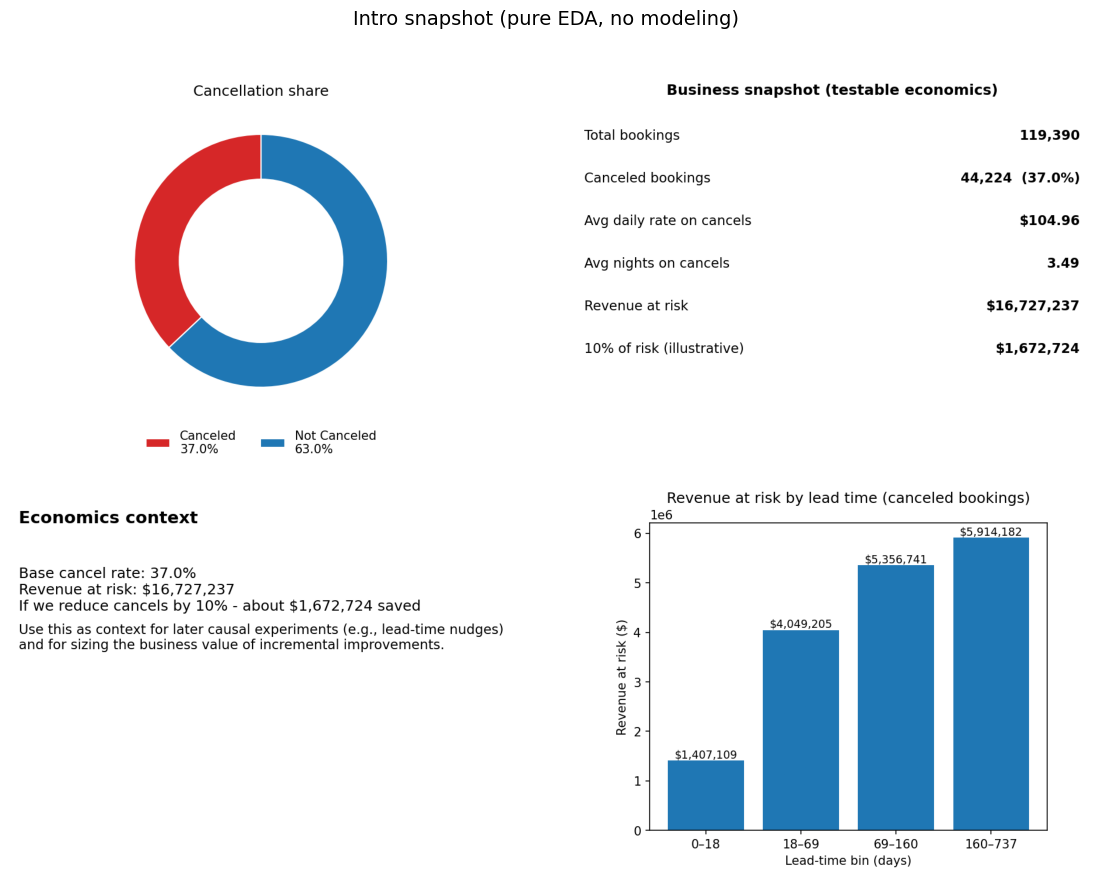

Saved individual parts:
 - /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/01_donut_cancellation_share.png
 - /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/02_business_snapshot.png
 - /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/03_economics_context_text.png
 - /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/04_revarisk_by_leadtime.png
Combined panel:
 - /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/00_intro_panel.png


In [8]:

df_raw = hotel_cancellations_raw_df.copy()

#
total_rows   = int(len(df_raw))
n_canceled   = int((df_raw['is_canceled']==1).sum())
base_rate    = n_canceled / total_rows if total_rows else 0.0

adr_clip     = df_raw.loc[df_raw['is_canceled']==1, 'adr'].clip(lower=0)
nights       = (df_raw['stays_in_weekend_nights'] + df_raw['stays_in_week_nights']).loc[df_raw['is_canceled']==1]
avg_adr      = float(adr_clip.mean())
avg_nights   = float(nights.mean())
rev_at_risk  = float((adr_clip * nights).sum())
ten_pct_save = 0.10 * rev_at_risk

def money(x):
    return f"${x:,.0f}"

#
# Donut: cancellation share
figA, axA = plt.subplots(figsize=(4.6, 4.6))
sizes  = [n_canceled, total_rows - n_canceled]
labels = [f"Canceled\n{base_rate:,.1%}", f"Not Canceled\n{1-base_rate:,.1%}"]

# colors: red then blue
colors = ['#d62728', '#1f77b4']  # mpl's classic red/blue
wedges, _ = axA.pie(
    sizes, startangle=90, colors=colors,
    wedgeprops=dict(linewidth=1, edgecolor='white')
)

# donut hole
centre_circle = plt.Circle((0,0), 0.65, fc='white')
axA.add_artist(centre_circle)

axA.set_title("Cancellation share")
axA.legend(wedges, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15), ncol=2, frameon=False)
figA.tight_layout()

path_donut = os.path.join(PLOTS_DIR, "01_donut_cancellation_share.png")
figA.savefig(path_donut, dpi=150, bbox_inches="tight"); plt.close(figA)


# [B] Business snapshot (KPIs)
# ============================================================
figB, axB = plt.subplots(figsize=(6.2, 4.6))
axB.axis('off')
axB.set_title("Business snapshot (testable economics)", pad=8, fontsize=12, weight='bold')

rows = [
    ("Total bookings",               f"{total_rows:,}"),
    ("Canceled bookings",            f"{n_canceled:,}  ({base_rate:,.1%})"),
    ("Avg daily rate on cancels",    f"${avg_adr:,.2f}"),
    ("Avg nights on cancels",        f"{avg_nights:.2f}"),
    ("Revenue at risk",              money(rev_at_risk)),
    ("10% of risk (illustrative)",   money(ten_pct_save)),
]
y0 = 0.90
for i, (k,v) in enumerate(rows):
    y = y0 - i*0.12
    axB.text(0.02, y, k, fontsize=11)
    axB.text(0.98, y, v, fontsize=11, ha='right', weight='bold')
figB.tight_layout()
path_kpis = os.path.join(PLOTS_DIR , "02_business_snapshot.png")
figB.savefig(path_kpis, dpi=150, bbox_inches="tight"); plt.close(figB)


# [C] Economics context (text)
# ============================================================
figC, axC = plt.subplots(figsize=(6.2, 4.6))
axC.axis('off')
axC.text(0.0, 0.95, "Economics context", fontsize=14, weight='bold', va='top')
axC.text(0.0, 0.80,
         f"Base cancel rate: {base_rate:,.1%}\n"
         f"Revenue at risk: {money(rev_at_risk)}\n"
         f"If we reduce cancels by 10% - about {money(ten_pct_save)} saved",
         fontsize=12, va='top')
axC.text(0.0, 0.65,
         "Use this as context for later causal experiments (e.g., lead-time nudges)\n"
         "and for sizing the business value of incremental improvements.",
         fontsize=11, va='top')
figC.tight_layout()
path_context = os.path.join(PLOTS_DIR , "03_economics_context_text.png")
figC.savefig(path_context, dpi=150, bbox_inches="tight"); plt.close(figC)


# [D] Revenue-at-risk by lead time (your bar)
# ============================================================
df = df_raw[df_raw['is_canceled']==1].copy()
df['adr_clip'] = df['adr'].clip(lower=0)
df['nights']   = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['rev']      = df['adr_clip'] * df['nights']

bins   = [0,18,69,160,737]
labels = ["0–18","18–69","69–160","160–737"]
df['lt_bin'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=True, include_lowest=True)
agg = df.groupby('lt_bin')['rev'].sum().reindex(labels)

figD, axD = plt.subplots(figsize=(5.2, 4.6))
axD.bar(agg.index.astype(str), agg.values)
axD.set_ylabel("Revenue at risk ($)"); axD.set_xlabel("Lead-time bin (days)")
axD.set_title("Revenue at risk by lead time (canceled bookings)")
for i,v in enumerate(agg.values):
    axD.text(i, v, f"${v:,.0f}", ha='center', va='bottom', fontsize=9)
figD.tight_layout()
path_revarisk = os.path.join(PLOTS_DIR , "04_revarisk_by_leadtime.png")
figD.savefig(path_revarisk, dpi=150, bbox_inches="tight"); plt.close(figD)


# Combined 2×2 panel (display only this)
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle("Intro snapshot (pure EDA, no modeling)", fontsize=14, y=0.98)

axes[0,0].imshow(plt.imread(path_donut));    axes[0,0].axis('off')
axes[0,1].imshow(plt.imread(path_kpis));     axes[0,1].axis('off')
axes[1,0].imshow(plt.imread(path_context));  axes[1,0].axis('off')
axes[1,1].imshow(plt.imread(path_revarisk)); axes[1,1].axis('off')

fig.tight_layout(rect=[0,0,1,0.96])
panel_path = os.path.join(PLOTS_DIR , "00_intro_panel.png")
fig.savefig(panel_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved individual parts:")
print(" -", path_donut)
print(" -", path_kpis)
print(" -", path_context)
print(" -", path_revarisk)
print("Combined panel:")
print(" -", panel_path)


# **DATA Cleaning**
cleaning.
####  Notes:
- drop columns with lots of missingness: company, agent.
- fill country with the mode ('PRT') to avoid dropping many rows.

## **data cleaning, feature engineering, dropping columns, Data Leakage**


----------------------------------------

# * **Basic Feature Engineering** ----

In [9]:
hotel_cancellations_df = hotel_cancellations_raw_df.copy()

# adding new features -- add total stay feature
#the number of total stay
hotel_cancellations_df['total_stay'] = hotel_cancellations_df['stays_in_weekend_nights'] + hotel_cancellations_df['stays_in_week_nights']
# the number of total guest adding adults, children, and babies
hotel_cancellations_df['total_guests'] = hotel_cancellations_df['adults'] + hotel_cancellations_df['children'] + hotel_cancellations_df['babies']
# customers who got different room than the one reserved
hotel_cancellations_df['different_room_assigned'] = (hotel_cancellations_df['reserved_room_type'] != hotel_cancellations_df['assigned_room_type']).astype(int)

In [10]:
# dropping the original columns
hotel_cancellations_df.drop(
    columns=[
        'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
        'children', 'babies', 'reserved_room_type', 'assigned_room_type'], inplace=True)

New Features Added:
- total_stay - added numbers from weekend nights and week nights
- total_guestts - added numbers from adults, children and babies
- different_room_assigned - yes or no to indicate if the reserved room is the assigned room

## * fix missing ---- and Dropna

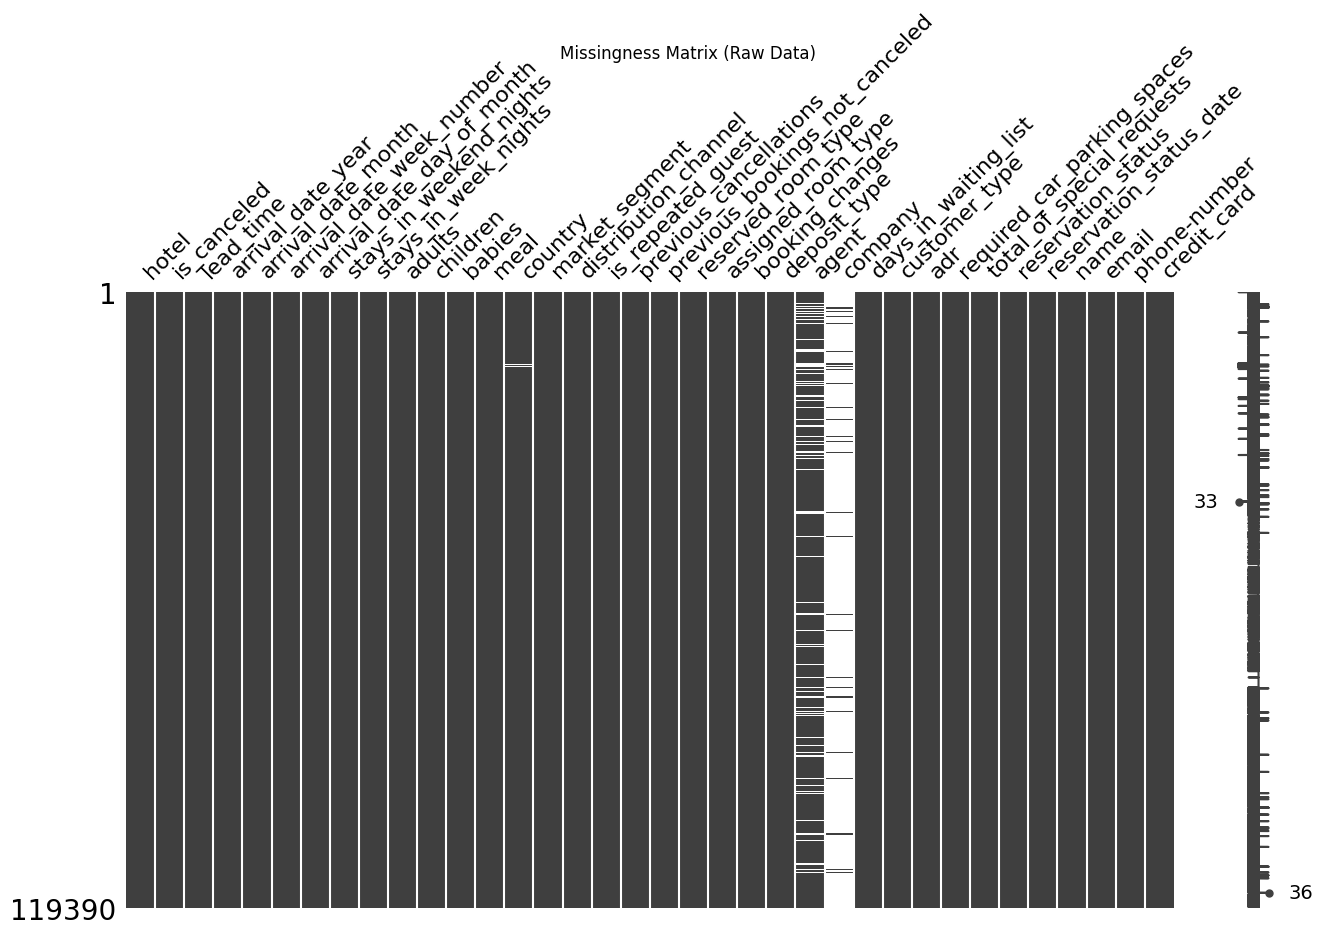

In [11]:
# * fix missing ----

# plot missing values
#matrix(hotel_cancellations_df)

# Snapshot before cleaning
rows_before = len(hotel_cancellations_raw_df)
cols_before = hotel_cancellations_raw_df.shape[1]

# Missingness visualization — DISPLAY + SAVE
missingness_path = os.path.join(PLOTS_DIR, "missingness_matrix.png")
ax = msno.matrix(hotel_cancellations_raw_df, figsize=(15, 8))

fig = ax.get_figure()
fig.suptitle("Missingness Matrix (Raw Data)", y=1.19)
fig.tight_layout()
fig.savefig(missingness_path, dpi=150, bbox_inches="tight")
plt.show()

### company is mostly missing values only, a lot of agents missing as well
drop those two columns

In [12]:
# count by country with sorting
country_count = hotel_cancellations_df['country'].value_counts().reset_index()

country_count.columns = ['country', 'count']
display(country_count.head(3))

# fix missing values and drop columns
hotel_cancellations_df = hotel_cancellations_df.drop(columns=['company', 'agent'])
# fill country with PRT -portugal since that is the mode
hotel_cancellations_df['country'] = hotel_cancellations_df['country'].fillna('PRT')

hotel_cancellations_df.dropna(inplace=True)

,country,count
0,PRT,48590
1,GBR,12129
2,FRA,10415


### cleaning steps:
- drop company and agent
- fill country with mode PRT
- drop any other rows with NA

In [13]:
hotel_cancellations_df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 119386 rows of 30 columns
hotel:                           object            ['Resort Hotel', 'Res ...
is_canceled:                     int64             [0, 0, 0, 0, 0, 0, 0, ...
lead_time:                       int64             [342, 737, 7, 13, 14, ...
arrival_date_year:               int64             [2015, 2015, 2015, 20 ...
arrival_date_month:              object            ['July', 'July', 'Jul ...
arrival_date_week_number:        int64             [27, 27, 27, 27, 27,  ...
arrival_date_day_of_month:       int64             [1, 1, 1, 1, 1, 1, 1, ...
meal:                            object            ['BB', 'BB', 'BB', 'B ...
country:                         object            ['PRT', 'PRT', 'GBR', ...
market_segment:                  object            ['Direct', 'Direct',  ...
distribution_channel:            object            ['Direct', 'Direct',  ...
is_repeated_guest:               int64             [0, 0, 0, 0, 0, 0, 0, ...
previous_ca

# 2.0 CORRELATION (LEVEL 1: ASSOCIATION) ----**

######  - Will use the new correlation funnel from pytimetk

In [14]:
# CSV_PATH_clean = os.path.join(BASE_DIR, "data/hotel_cancellations_clean.csv")
# hotel_cancellations_df = pd.read_csv(CSV_PATH_clean)
#hotel_cancellations_df.head(3)
len(hotel_cancellations_df.columns)

30

In [15]:
hotel_cancellations_df= hotel_cancellations_df[['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
'arrival_date_day_of_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest',
'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'deposit_type', 'days_in_waiting_list',
'customer_type', 'adr', 'required_car_parking_spaces',
'total_of_special_requests', 'reservation_status', 'total_stay', 'total_guests', 'different_room_assigned']]
print(len(hotel_cancellations_df.columns))
hotel_cancellations_df.head(3)


25


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,meal,country,market_segment,...,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,total_stay,total_guests,different_room_assigned
0,Resort Hotel,0,342,2015,July,27,1,BB,PRT,Direct,...,No Deposit,0,Transient,0.0,0,0,Check-Out,0,2.0,0
1,Resort Hotel,0,737,2015,July,27,1,BB,PRT,Direct,...,No Deposit,0,Transient,0.0,0,0,Check-Out,0,2.0,0
2,Resort Hotel,0,7,2015,July,27,1,BB,GBR,Direct,...,No Deposit,0,Transient,75.0,0,0,Check-Out,1,1.0,1


In [16]:
# * binarize ----
df_binarized = hotel_cancellations_df.binarize()
# turns categoricals into 0/1 dummy columns (one-hot). .... default to 4 bins for columns with a lot of categories
df_binarized.head(3)

,lead_time__0.0_18.0,lead_time__18.0_69.0,lead_time__69.0_160.0,lead_time__160.0_737.0,arrival_date_week_number__1.0_16.0,arrival_date_week_number__16.0_28.0,arrival_date_week_number__28.0_38.0,arrival_date_week_number__38.0_53.0,arrival_date_day_of_month__1.0_8.0,arrival_date_day_of_month__8.0_16.0,...,total_of_special_requests__0,total_of_special_requests__1,total_of_special_requests__2,total_of_special_requests__3,total_of_special_requests__-OTHER,reservation_status__Canceled,reservation_status__Check-Out,reservation_status__No-Show,different_room_assigned__0,different_room_assigned__1
0,0,0,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
1,0,0,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1


#### **Correlate**

 * Correlate ---- converts the target into a dummy column named is_canceled__1 for the “1 = canceled” class
- Computes correlation of every (binarized) feature with the target column is_canceled__1.
- High absolute correlation ⇒ strong association with cancelation (not causal).

https://business-science.github.io/pytimetk/reference/plot_correlation_funnel.html#:~:text=plot_correlation_funnel

In [17]:
df_correlated = df_binarized.correlate(target="is_canceled__1")

df_correlated.head(5)

,feature,bin,correlation
25,is_canceled,1,1.000000
24,is_canceled,0,-1.000000
100,reservation_status,Check-Out,-1.000000
99,reservation_status,Canceled,0.978433
84,deposit_type,Non Refund,0.481488


In [18]:
# *  assess correlation before causation
df_correlated.plot_correlation_funnel()

reservation_status has dots near ±1 so it encodes the outcome (leakage). might need to be dropped modeling.

deposit_type has strong positive dots and some deposit types (e.g., Non Refund ) associate with higher cancellation rates.

Long-lead lead_time bins are on the right and long lead bookings cancel more; short lead bins should lean left.

How to read:

Dots on the left contribute less to cancellation. <=0 Dots on the right have correlate more to canceled reservations. >=0

Features are ordered in order of how correlated they are to is_canceled. (the y-axis order is based on each feature's single strongest bin (the max |correlation| among its bins with is_canceled__1). so a feature jumps to the top if any one of its bins has a big correlation—even if the other bins are weak. )

### * Drop Unneeded Columns ---- Data Leakage

In [19]:
# drop Unneeded Columns ----  reservation_status is the date the booking’s final status was set
 #(e.g., when it was canceled or checked-out). That happens after the booking decision.

hotel_cancellations_subset_df = hotel_cancellations_df.drop(columns=['reservation_status'])
# CSV_PATH_data_save = os.path.join(BASE_DIR, "data/hotel_cancellations_clean.csv")
# hotel_cancellations_df.to_csv(CSV_PATH_data_save, index=False)

# * Subset features that describe the system ---- *

### Further future engineering

In [20]:
# selecting specific columns -- we want to keep -- columns on the lower part of the plot contribute very tiny information to correlation
hotel_cancellations_subset_df = hotel_cancellations_subset_df[[
    'is_canceled', 'deposit_type', 'country', 'previous_cancellations',
    'lead_time', 'total_of_special_requests', 'different_room_assigned',
    'market_segment', 'required_car_parking_spaces', 'distribution_channel',
    'hotel', 'customer_type', 'previous_bookings_not_canceled',
    'is_repeated_guest']]

# creating new columns based on the 'country' column -- creating new features on heavy correlation bins
hotel_cancellations_subset_df['country_PRT'] =(hotel_cancellations_subset_df['country'] == 'PRT').astype(int)
hotel_cancellations_subset_df['country_other']=(hotel_cancellations_subset_df['country'] != 'PRT').astype(int)

# dropping the original 'country' column
hotel_cancellations_subset_df.drop(columns=['country'], inplace=True)
#save data
#hotel_cancellations_subset_df.to_csv("data/hotel_cancellations_subset.csv", index=False)

#SV_PATH_subset = os.path.join(BASE_DIR, "data/hotel_cancellations_subset.csv")
#hotel_cancellations_subset_df.to_csv(CSV_PATH_subset, index=False)

In [21]:
hotel_cancellations_subset_df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 119386 rows of 15 columns
is_canceled:                     int64             [0, 0, 0, 0, 0, 0, 0, ...
deposit_type:                    object            ['No Deposit', 'No De ...
previous_cancellations:          int64             [0, 0, 0, 0, 0, 0, 0, ...
lead_time:                       int64             [342, 737, 7, 13, 14, ...
total_of_special_requests:       int64             [0, 0, 0, 0, 1, 1, 0, ...
different_room_assigned:         int64             [0, 0, 1, 0, 0, 0, 0, ...
market_segment:                  object            ['Direct', 'Direct',  ...
required_car_parking_spaces:     int64             [0, 0, 0, 0, 0, 0, 0, ...
distribution_channel:            object            ['Direct', 'Direct',  ...
hotel:                           object            ['Resort Hotel', 'Res ...
customer_type:                   object            ['Transient', 'Transi ...
previous_bookings_not_canceled:  int64             [0, 0, 0, 0, 0, 0, 0, ...
is_repeated

# **Model Building**

#**Multivariate GLM: pre-treatment features only**
## Confounding variables
# ------------------------
Identify categorical vs numeric (object = categorical here)

steps:
- dummify categorical variables
- ensure numeric dtypes
- train/test split
- add intercept
- fit model - GLM Binomial (logit) with L1 (Lasso) regularization
# ------------------------

### GLM Generalized Linear Model. It's the statsmodels class for many regression types
 - sm.add_constant(X_train) = add an intercept column of 1s so the model can learn the baseline cancelation level; all other coefficients become differences vs that baseline."""
 - family=Binomial() = tells GLM the outcome is binary (0/1). That chooses the right likelihood for classification.
 - link=logit() = the link function that maps linear scores to probabilities via the logistic curve.
 - fit with a elastic net penalty to prevent overfitting. .. leaning towards L1(Lasso) with alpha=0.01 overall penalty  strength.

In [22]:
# preprocessing
df = hotel_cancellations_subset_df.copy()
df['lead_time'] = pd.qcut(df['lead_time'], q=4, duplicates='drop')
df.glimpse()
df = pd.get_dummies(df, drop_first=True)
print("")
print("After get dummies: Final Columns")
print("")
df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 119386 rows of 15 columns
is_canceled:                     int64             [0, 0, 0, 0, 0, 0, 0, ...
deposit_type:                    object            ['No Deposit', 'No De ...
previous_cancellations:          int64             [0, 0, 0, 0, 0, 0, 0, ...
lead_time:                       category          [Interval(160.0, 737. ...
total_of_special_requests:       int64             [0, 0, 0, 0, 1, 1, 0, ...
different_room_assigned:         int64             [0, 0, 1, 0, 0, 0, 0, ...
market_segment:                  object            ['Direct', 'Direct',  ...
required_car_parking_spaces:     int64             [0, 0, 0, 0, 0, 0, 0, ...
distribution_channel:            object            ['Direct', 'Direct',  ...
hotel:                           object            ['Resort Hotel', 'Res ...
customer_type:                   object            ['Transient', 'Transi ...
previous_bookings_not_canceled:  int64             [0, 0, 0, 0, 0, 0, 0, ...
is_repeated

In [23]:
# ensure numeric int dtypes for booleans
for c in df.columns:
    if df[c].dtype == 'bool':
        df[c] = df[c].astype(int)

# train / test split
train_df = df.sample(frac=0.8, random_state=123)
test_df  = df.drop(train_df.index)

#  X / y
y_train = train_df['is_canceled'].astype(int)
X_train = train_df.drop(columns=['is_canceled']).copy()

# ---- STABILITY FIXES (quasi-separation / rare dummies) ----
# bin parking to avoid near-constant numeric
if 'required_car_parking_spaces' in X_train.columns:
    X_train['has_parking'] = (X_train['required_car_parking_spaces'] >= 1).astype(int)
    X_train.drop(columns=['required_car_parking_spaces'], inplace=True)

# identify binary columns
def is_binary(col):
    vals = pd.unique(col.dropna())
    return set(vals).issubset({0,1})

bin_cols = [c for c in X_train.columns if is_binary(X_train[c])]

# drop ultra-rare dummies (<0.5% ones)
prev = (X_train[bin_cols].sum(axis=0) / len(X_train)).sort_values()
rare_thresh = 0.005  # 0.5%
rare_cols = prev[prev < rare_thresh].index.tolist()

# detect perfect separation (whenever x==1 -> y all 0 or all 1)
sep_cols = []
for c in bin_cols:
    mask = X_train[c].values == 1
    if mask.any():
        y_when1 = y_train[mask]
        if y_when1.mean() in (0.0, 1.0):  # perfectly predicts
            sep_cols.append(c)

# Known to cause issue sometimes: drop if present
always_drop = [c for c in ['distribution_channel_Undefined'] if c in X_train.columns]

to_drop = sorted(set(rare_cols) | set(sep_cols) | set(always_drop))
if to_drop:
    print(f"Dropping {len(to_drop)} unstable columns:", to_drop)
X_train_trim = X_train.drop(columns=to_drop, errors='ignore')


Dropping 5 unstable columns: ['customer_type_Group', 'deposit_type_Refundable', 'distribution_channel_GDS', 'distribution_channel_Undefined', 'has_parking']


In [24]:
# add constant
X_train_c = sm.add_constant(X_train_trim, has_constant='add')

# penalized fit (Ridge/L2) for stability & performance
model_ridge = sm.GLM(y_train, X_train_c, family=sm.families.Binomial(), link=sm.families.links.logit())
res_ridge = model_ridge.fit_regularized(method='elastic_net', alpha=0.00, L1_wt=0.0)  # L2 only

# test with same transforms & columns
X_test = test_df.drop(columns=['is_canceled']).copy()

if 'required_car_parking_spaces' in X_test.columns:
    X_test['has_parking'] = (X_test['required_car_parking_spaces'] >= 1).astype(int)
    X_test.drop(columns=['required_car_parking_spaces'], inplace=True)

X_test_trim = X_test.drop(columns=to_drop, errors='ignore')
X_test_c = sm.add_constant(X_test_trim, has_constant='add')
# align columns exactly
X_test_c = X_test_c.reindex(columns=X_train_c.columns, fill_value=0)

y_test = test_df['is_canceled'].astype(int)

# predict & AUC (ridge)
pred_prob = res_ridge.predict(X_test_c)
roc_auc = roc_auc_score(y_test, pred_prob)
print(f"ROC AUC (ridge): {roc_auc:.4f}")
print("'const' in ridge params?", 'const' in res_ridge.params.index)


# Odds-ratio table (ridge)
coef = pd.DataFrame(res_ridge.params, columns=['coef'])
coef['odds_ratio'] = np.exp(coef['coef'])
coef = coef.sort_values('coef', key=np.abs, ascending=False)
print("\nTop coefficients (ridge):")
print(coef.head(15))

# to try as option- Unpenalized refit on trimmed matrix (pretty .summary()).
#    Wrap in try/except—if it still separates, keep ridge as the final.
try:
    glm_unpen = sm.GLM(y_train, X_train_c, family=sm.families.Binomial(), link=sm.families.links.logit())
    res_unpen = glm_unpen.fit(maxiter=100)
    print("\nUnpenalized GLM summary (trimmed features):")
    print(res_unpen.summary())
except Exception as e:
    print("\nUnpenalized refit still unstable; using ridge only.")
    print("Reason:", repr(e))

ROC AUC (ridge): 0.8810
'const' in ridge params? True

Top coefficients (ridge):
                                  coef  odds_ratio
deposit_type_Non Refund       4.634437  102.969910
previous_cancellations        2.128288    8.400470
different_room_assigned      -1.982768    0.137688
lead_time_(160.0, 737.0]      1.766519    5.850453
country_other                -1.474347    0.228928
lead_time_(69.0, 160.0]       1.430111    4.179162
const                        -1.293726    0.274247
lead_time_(18.0, 69.0]        1.248210    3.484102
market_segment_Online TA      0.923576    2.518280
is_repeated_guest            -0.847471    0.428497
customer_type_Transient       0.830776    2.295098
market_segment_Offline TA/TO -0.785063    0.456091
total_of_special_requests    -0.746335    0.474101
market_segment_Corporate     -0.742046    0.476139
distribution_channel_Direct  -0.570942    0.564993

Unpenalized GLM summary (trimmed features):
                 Generalized Linear Model Regression Resul

ROC AUC: 0.8810

Dataframe: shows the log=odd logits....with the odds ratio showing how much that feature adds influence more than the constant. also showing the in the coef model results.

- Pseudo R-squ. (CS): 0.4021. For a tabular churn/cancel problem, that's strong for a purely pre-treatment spec.

**Columns**

coef
The estimated effect on log-odds (logit scale). Positive ⇒ higher cancel odds; negative ⇒ lower.
Convert to odds ratio with exp(coef).

std err
The standard error of the coefficient estimate (sampling uncertainty). Smaller means tighter estimate. It comes from the model's covariance estimate (yours says nonrobust). You can request robust SEs if needed.

z
Test statistic: z = coef / std_err. It measures how many SEs the estimate is from 0. 0 means no effect.

P>|z|
Two-sided p-value for testing H₀: coef = 0. Small p (e.g., <0.05) - the effect is statistically different from 0 under the model's assumptions.

[0.025, 0.975]
The 95% confidence interval for the coefficient on the log-odds scale. Exponentiate the bounds to get a CI for the odds ratio.

**Example deposit_type_Non Refund**

z & p: The estimate (4.6304) is 36 SEs away from 0 - extremely incompatible with 'no effect' - so statistically significant.

Odds ratio: exp(4.6304) = 102.5
Sentence: Holding other variables fixed, bookings with “Non Refund” have about 102.5 higher odds of cancellation than the baseline deposit type.

OR 95% CI: exp(4.381) ≈ 79.6, exp(4.879) ≈ 131.5
Sentence: A plausible range for that odd ratio  from 80 to 132.

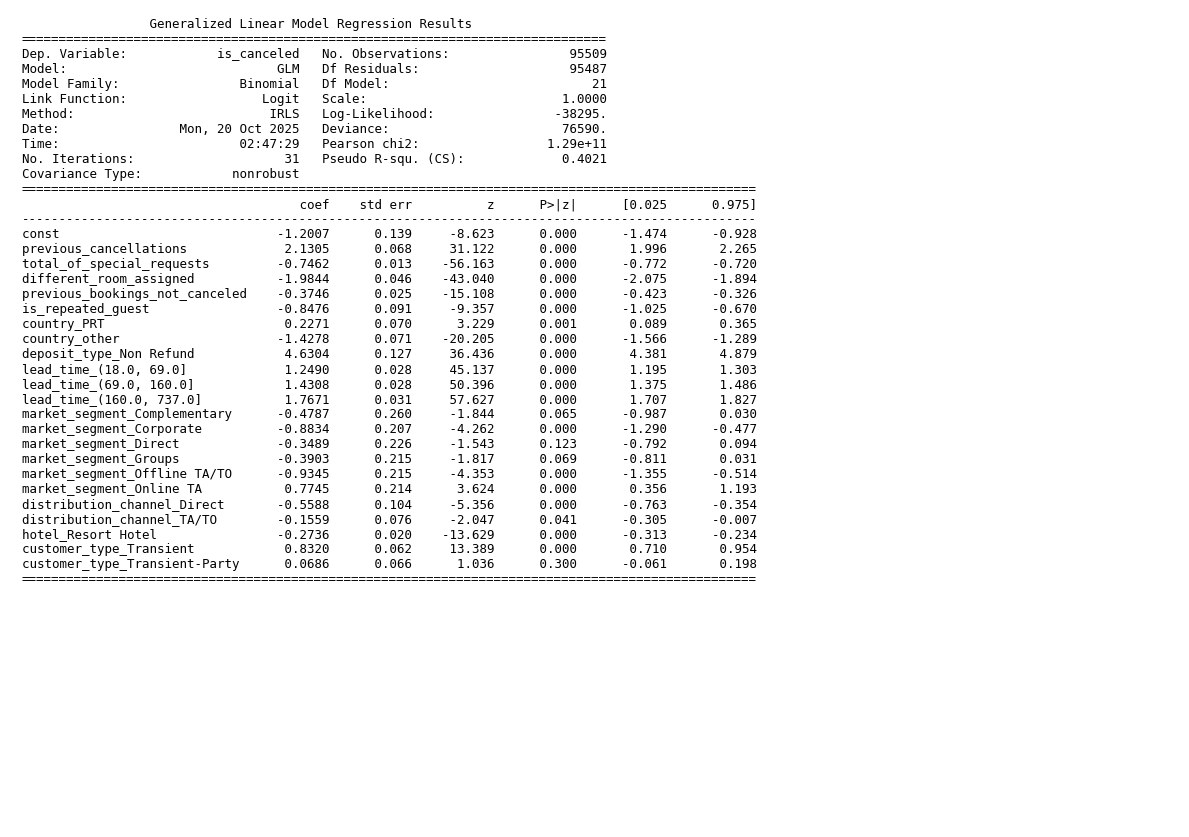

Saved: /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/glm_unpen_summary.txt
Saved: /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/glm_unpen_summary.png


In [25]:
# make sure folder exists
os.makedirs(PLOTS_DIR, exist_ok=True)

# save as text
glm_txt_path = os.path.join(PLOTS_DIR, "glm_unpen_summary.txt")
with open(glm_txt_path, "w") as f:
    f.write(str(res_unpen.summary()))

# save as PNG image
summary_str = str(res_unpen.summary())
fig = plt.figure(figsize=(12, 14))
plt.text(0.01, 0.99, summary_str, va="top", ha="left", family="monospace", fontsize=9)
plt.axis("off")
glm_png_path = os.path.join(PLOTS_DIR, "glm_unpen_summary.png")
fig.subplots_adjust(left=0, right=1, top=0.001, bottom=-.01)
fig.tight_layout()
fig.savefig(glm_png_path, dpi=200, bbox_inches="tight", pad_inches=0.0)
plt.show()
plt.close(fig)

print("Saved:", glm_txt_path)
print("Saved:", glm_png_path)

  K%  n_flagged  Precision@K  Recall@K   Lift@K
 1.0        239     0.970711  0.025678 2.565321
 2.0        478     0.985356  0.052131 2.604022
 5.0       1194     0.993300  0.131267 2.625016
10.0       2388     0.996650  0.263420 2.633869
20.0       4776     0.906616  0.479247 2.395936


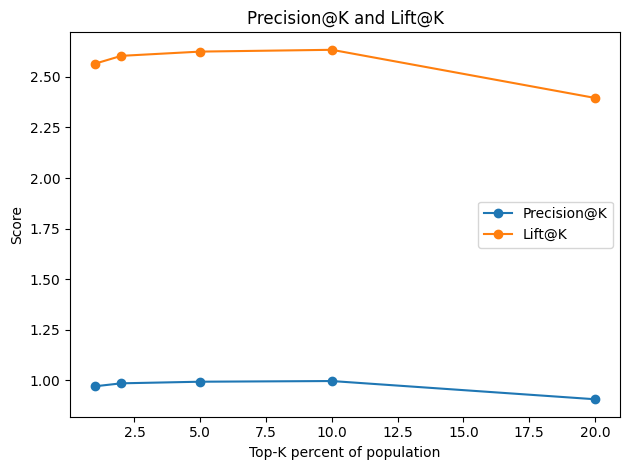

Saved: /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/precision_lift_at_k.csv and /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/precision_lift_at_k.png


In [26]:
# inputs
y = np.asarray(y_test).astype(int)
p = np.asarray(pred_prob).astype(float)
mask = np.isfinite(p)
y, p = y[mask], p[mask]
plots_dir = PLOTS_DIR if 'PLOTS_DIR' in globals() else "./plots"
os.makedirs(plots_dir, exist_ok=True)

def precision_and_lift_at_k(y_true, y_score, ks=(0.01, 0.02, 0.05, 0.10, 0.20)):
    order = np.argsort(-y_score)
    y_sorted = y_true[order]
    n = len(y_true)
    total_pos = y_true.sum()
    rows = []
    for k in ks:
        m = max(1, int(np.ceil(k*n)))
        topk = y_sorted[:m]
        precision_k = topk.mean() # positives / selected
        recall_k = topk.sum() / total_pos if total_pos > 0 else np.nan
        lift_k = precision_k / (total_pos / n) if total_pos > 0 else np.nan
        rows.append({"K%": 100*k, "n_flagged": m,
                     "Precision@K": precision_k, "Recall@K": recall_k, "Lift@K": lift_k})
    return pd.DataFrame(rows)

df_k = precision_and_lift_at_k(y, p)
print(df_k.to_string(index=False))

# save CSV
csv_path = os.path.join(plots_dir, "precision_lift_at_k.csv")
df_k.to_csv(csv_path, index=False, float_format="%.4f")

# simple plot
plt.figure()
plt.plot(df_k["K%"], df_k["Precision@K"], marker="o", label="Precision@K")
plt.plot(df_k["K%"], df_k["Lift@K"], marker="o", label="Lift@K")
plt.xlabel("Top-K percent of population")
plt.ylabel("Score")
plt.title("Precision@K and Lift@K")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "precision_lift_at_k.png"), dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", csv_path, "and", os.path.join(plots_dir, "precision_lift_at_k.png"))


Saved:
 - /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/roc_curve.png
 - /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/calibration_plot.png
 - /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/roc_and_calibration_panel.png


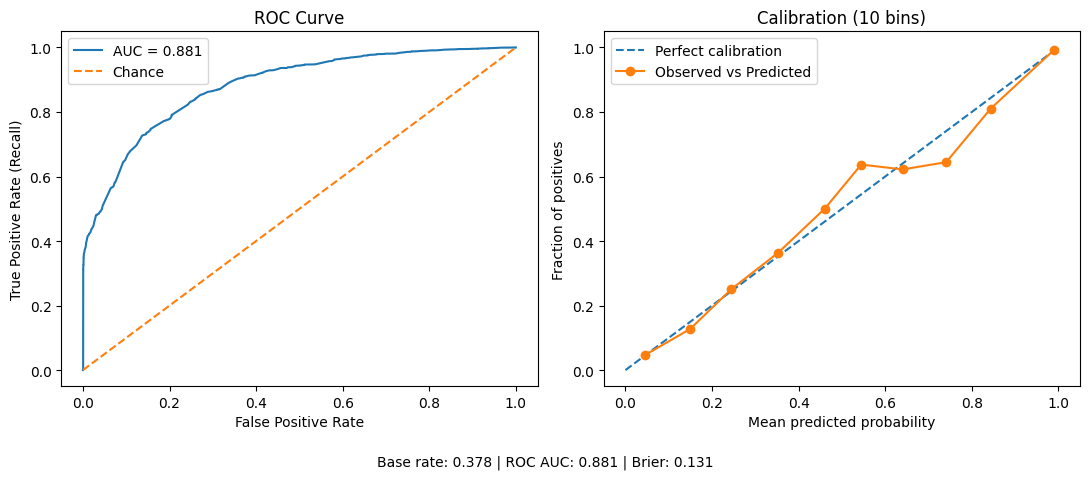

In [27]:
# guard
if 'y_test' not in globals() or 'pred_prob' not in globals():
    print("y_test / pred_prob not found. Run the modeling cell first.")
else:
    y = np.asarray(y_test).astype(int)
    p = np.asarray(pred_prob).astype(float)
    mask = np.isfinite(p)
    y, p = y[mask], p[mask]

    plots_dir = PLOTS_DIR if 'PLOTS_DIR' in globals() else "./plots"
    os.makedirs(plots_dir, exist_ok=True)

    # Metrics
    auc = float(roc_auc_score(y, p))
    brier = float(brier_score_loss(y, p))
    base_rate = float(y.mean())

    # Curves
    fpr, tpr, _ = roc_curve(y, p)
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=10)

    # plots
    # ROC
    fig_roc = plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve"); plt.legend(); plt.tight_layout()
    roc_path = os.path.join(plots_dir, "roc_curve.png")
    fig_roc.savefig(roc_path, dpi=150, bbox_inches="tight")
    plt.close(fig_roc)

    # Calibration
    fig_cal = plt.figure()
    plt.plot([0,1], [0,1], linestyle="--", label="Perfect calibration")
    plt.plot(mean_pred, frac_pos, marker="o", label="Observed vs Predicted")
    plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
    plt.title("Calibration Plot (10 bins)"); plt.legend(); plt.tight_layout()
    cal_path = os.path.join(plots_dir, "calibration_plot.png")
    fig_cal.savefig(cal_path, dpi=150, bbox_inches="tight")
    plt.close(fig_cal)


    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    # Left: ROC
    axes[0].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    axes[0].plot([0,1], [0,1], linestyle="--", label="Chance")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate (Recall)")
    axes[0].set_title("ROC Curve")
    axes[0].legend()
    # Right: Calibration
    axes[1].plot([0,1], [0,1], linestyle="--", label="Perfect calibration")
    axes[1].plot(mean_pred, frac_pos, marker="o", label="Observed vs Predicted")
    axes[1].set_xlabel("Mean predicted probability")
    axes[1].set_ylabel("Fraction of positives")
    axes[1].set_title("Calibration (10 bins)")
    axes[1].legend()

    fig.suptitle(f"Base rate: {base_rate:.3f} | ROC AUC: {auc:.3f} | Brier: {brier:.3f}",
                 y=0.02, fontsize=10)
    fig.tight_layout(rect=[0,0.04,1,1])

    panel_path = os.path.join(plots_dir, "roc_and_calibration_panel.png")
    fig.savefig(panel_path, dpi=150, bbox_inches="tight")


    print("Saved:")
    print(" -", roc_path)
    print(" -", cal_path)
    print(" -", panel_path)


**ROC curve**— discrimination. The model ranks likely cancellations well: AUC 0.881 (0.50 = random, >0.80 = good). This means, across thresholds, a canceled booking is much more likely to receive a higher score than a non-canceled one.

**Calibration plot**

Calibration — probability accuracy. Predicted probabilities closely match observed cancellation rates across bins (points near the 45° line). Brier 0.131 vs a naïve “always predict base rate” score of ~0.235, indicating well-calibrated risk estimates suitable for cost/benefit decisions.

# **Causal Experiment and Design**

### **Big variables to explore:**

Deposit_type Non-Refund (OR ~103x): huge selection + major commercial side-effects; not a clean knob for a first causal pass.
 - but has a lot of confounding variables:
    - Traveler intent: last-minute plans vs. far-in-advance planners; business vs. leisure; locals vs. international.
    - Price sensitivity: many non-refund offers are cheaper - attracts a different mix of guests.
    - Channel: OTAs/promotions often push non-refund; channels differ in customer behavior and cancellation norms.
    - Timing/season: during peaks, properties list more non-refund inventory.

Previous_cancellations: past behavior, not manipulable.

Do groups tend to cancel more? (the plot shows that groups do tend to cancle more but limiting reservation numbers might negativitly impact how much revenue is spent when large groups of people do come) - not good for marketing - out of our control

### Lead - times : strong candidate for your causal experiment

# *4.0 Causal Hypothesis*

Question to explore:
-  **Will reducing lead time reduce cancellation? (with in our control)**

Actionable & manipulable

it can be moved with policies: limited booking window, “book-later” discounts, reminder nudges, waitlist releases ...

#**Univariate: lead_time**

###Simple Logistic Model For only Lead Time Column --- univariate model—just lead time


### BASELINE PREDICTIVE SANITY CHECKS (no causal claims)
------------------------------------------------------------
Goal: get a feel for signal using *pre-treatment* features only.
Notes:
- Univariate logistic on binned lead_time (interpretable).
- Multivariate GLM (Binomial logit) with regularization (L1) to avoid overfit.
- Simple train/test ROC-AUC to confirm there's learnable structure.
- this is as *sanity checks*; causal effects are Notebook 02.

In [28]:
# preparing the data
lead_time_df = hotel_cancellations_subset_df[['is_canceled', 'lead_time']].copy()
#binarize the lead time into 4 categories bins -- needed to make the logistic model a bit non linear since the lead time data is non linear bin helps linear models to work with it.
lead_time_df['lead_time_binned'] = pd.qcut(lead_time_df['lead_time'], q=4, duplicates='drop')

# one-hot encoding (with dropping the first category to avoid multicollinearity)
lead_time_dummies = pd.get_dummies(lead_time_df['lead_time_binned'], drop_first=True)

#One-hotting K bins and keeping an intercept causes perfect multicollinearity (the dummy-variable trap) because the dummies sum to 1 for every row, so intercept = Q1 + Q2 + … + QK.

#The fix is to drop one dummy (drop_first=True): the dropped bin becomes the baseline, implicitly represented by the intercept.

#Each remaining coefficient then tells you how much higher/lower the outcome (e.g., log-odds) is relative to the baseline, and you don’t lose information in predictions.

In [29]:
X = lead_time_dummies.astype(float)
y = lead_time_df['is_canceled'].astype(float)

# add a constant to the model (intercept) - adds the intercept so the baseline has its own level, and other coefficients become “difference vs baseline.”
X = sm.add_constant(X) # reg, the intercept = the model’s predicted value when all features are 0.

# fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

#summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.608661
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               119386
Model:                          Logit   Df Residuals:                   119382
Method:                           MLE   Df Model:                            3
Date:                Mon, 20 Oct 2025   Pseudo R-squ.:                 0.07662
Time:                        02:47:32   Log-Likelihood:                -72666.
converged:                       True   LL-Null:                       -78695.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.7643      0.016   -108.441      0.000      -1.796      -1.732
(18.0, 69.0]     

Reading the Log-odds numbers:

const = -1.7643 is the intercept: the log-odds of cancelation for the baseline bin (lead time in the lowest quartile, about 0-18 days). Convert to probability:

p=1/(1+e^(-(-1.7643))) = 0.146 meaning there is about 14.6% percent of cancle rate in the first 0-18 days of lead time.

Each lead-time bin coef is added to the intercept:

Big picture: compared to short lead times (baseline ~14.6%), longer lead times sharply raise cancel probability. (Note the model is univariate here—just lead time—so add other features to control for confounders. The pseudo 𝑅 2 R 2 of 0.077 shows modest explanatory power.) (Interpretation: ~7.7% improvement over an intercept-only model = small explanatory power (expected, since this model uses lead_time only))

In [30]:
#baseline (0–18): to get probability from a log-odds do (logistic (sigmoid) function:) : log-odds = −1.7643 → p = 1/(1+np.exp(1.7643)) ≈ 0.146
print("Probability of baseline cancel rate:")
print(1/(1+np.exp(1.7643)))

print("")
print("")
#these are exponentiated coefficients (exp(beta)), i.e., odds or odds ratios:
print("These are exponentiated coefficients (exp(beta)), i.e., odds or odds ratios:")
print("")
print(np.exp(-1.7643), f"   #baseline const for the baseline leadtime dates 0-18") #baseline const for the baseline leadtime dates 0-18

# logistic Regression produces Log-odds - Odds turn a probability into ratio
print(np.exp(1.98), f"    # 160+ days -> 7.2X risk of cancellation from baseline")   # 160+ days -> 7.2X risk of cancellation from baseline
print(np.exp(1.47), f"    # 69–160 days -> 4.3X risk")   # 69–160 days -> 4.3X risk
print(np.exp(1.18), f"    # 18–69 days  -> 3.25X risk")  # 18–69 days  -> 3.25X risk
print('compared to short lead times (baseline ~14.6%), longer lead times sharply raise cancel probability.')

Probability of baseline cancel rate:
0.1462526127061175


These are exponentiated coefficients (exp(beta)), i.e., odds or odds ratios:

0.17130665918603097    #baseline const for the baseline leadtime dates 0-18
7.242742985161012     # 160+ days -> 7.2X risk of cancellation from baseline
4.349235141062741     # 69–160 days -> 4.3X risk
3.2543742028896707     # 18–69 days  -> 3.25X risk
compared to short lead times (baseline ~14.6%), longer lead times sharply raise cancel probability.


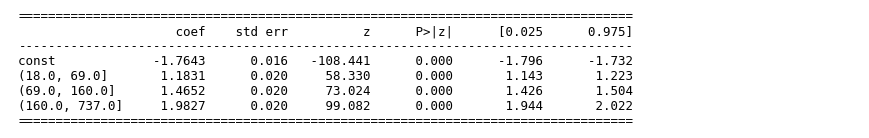

Saved: /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/leadtime_logit_coeff_table.txt
Saved: /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/leadtime_logit_coeff_table.png


In [31]:
os.makedirs(PLOTS_DIR, exist_ok=True)

# 1) Pull just the coefficient table text (the block you showed)
coef_text = result.summary().tables[1].as_text()

# 2) Save as .txt (optional)
coef_txt_path = os.path.join(PLOTS_DIR, "leadtime_logit_coeff_table.txt")
with open(coef_txt_path, "w") as f:
    f.write(coef_text)

# 3) Render the same table as a tightly-cropped PNG
fig = plt.figure(figsize=(8.5, 3.6), facecolor="white")
plt.text(0.01, 0.99, coef_text, va="top", ha="left", family="monospace", fontsize=9)
plt.axis("off")
fig.subplots_adjust(left=0, right=1, top=0.1, bottom=0)
coef_png_path = os.path.join(PLOTS_DIR, "leadtime_logit_coeff_table.png")
fig.savefig(coef_png_path, dpi=220, bbox_inches="tight", pad_inches=0.0)
plt.show()
plt.close(fig)

print("Saved:", coef_txt_path)
print("Saved:", coef_png_path)

### **Experiment**
Evaluate whether **offering a 10% discount** to *eligible guests* (e.g., Groups with long lead times) **reduces cancellations** and **increases value** versus control.

In [32]:
rng = np.random.default_rng(44)

BASE_DIR = "/content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/"
EXP_PATH = os.path.join(BASE_DIR, "data/hotel_cancellations_experiment2.csv")

#  cleaned, original dataset
base = hotel_cancellations_df.copy()

# ensure engineered / needed columns exist
if "different_room_assigned" not in base.columns:
    if {"reserved_room_type", "assigned_room_type"}.issubset(base.columns):
        base["different_room_assigned"] = (
            base["reserved_room_type"].astype(str) != base["assigned_room_type"].astype(str)
        ).astype(int)
    else:
        base["different_room_assigned"] = np.where(
            rng.random(len(base)) < 0.10, 1, 0
        ).astype(int)

# country flags
base["country"] = base["country"].fillna("Unknown")
base["country_PRT"] = (base["country"] == "PRT").astype(int)
base["country_other"] = (base["country"] != "PRT").astype(int)

# coerce numerics
for c in [
    "is_canceled", "lead_time", "total_of_special_requests", "required_car_parking_spaces",
    "previous_cancellations", "previous_bookings_not_canceled", "is_repeated_guest",
    "different_room_assigned"
]:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors="coerce").fillna(0).astype(int)

#eligible pool: Groups & lead_time > 90
eligible = base.query('market_segment == "Groups" and lead_time > 90').copy()
assert len(eligible) >= 500, f"Eligible size {len(eligible)} < 500"

# Sample exactly 500
exp = eligible.sample(n=500, random_state=42).copy()

# assignment: 250 control / 250 treatment
exp["treatment_control"] = "control"
treat_idx = exp.sample(n=250, random_state=43).index
exp.loc[treat_idx, "treatment_control"] = "treatment"

# acceptance: exactly 62 accepts in treatment
exp["accept_offer"] = 0
is_treat = exp["treatment_control"].eq("treatment")

# Use a probability model to *weight* selection, but force exactly 62
p_accept = (
    0.20
    + 0.0004 * exp["lead_time"].clip(upper=240)
    + 0.03   * exp["total_of_special_requests"].clip(upper=5)
)
p_accept = p_accept.clip(0.05, 0.75)
weights = p_accept[is_treat].to_numpy()
weights = weights / weights.sum()

treated_indices = exp.index[is_treat].to_numpy()
n_accept = min(62, is_treat.sum())  # should be 62
accept_indices = rng.choice(treated_indices, size=n_accept, replace=False, p=weights)
exp.loc[accept_indices, "accept_offer"] = 1

# new_lead_time: earlier only if accepted
exp["new_lead_time"] = exp["lead_time"].astype(int)
shift = rng.integers(14, 61, size=n_accept)  # 14–60 days earlier
exp.loc[accept_indices, "new_lead_time"] = (
    (exp.loc[accept_indices, "lead_time"] - shift).clip(lower=0)
).astype(int)

# generate post-period outcome: is_canceled
# use empirical baseline cancel rates by lead_time quartiles from the *original* data
base_lead = pd.to_numeric(base["lead_time"], errors="coerce").fillna(0)
qt = base_lead.quantile([0, .25, .5, .75, 1.0]).to_numpy()
bins = pd.cut(base_lead, bins=qt, include_lowest=True, duplicates="drop")
hist_rate = base["is_canceled"].astype(int).groupby(bins).mean().to_dict()

def lead_to_rate(lt):
    b = pd.cut(pd.Series([float(lt)]), bins=qt, include_lowest=True, duplicates="drop").iloc[0]
    return float(hist_rate.get(b, base["is_canceled"].mean()))

# baseline prob from *old* lead_time
p0 = exp["lead_time"].map(lead_to_rate).astype(float)

# if accepted & rebooked earlier, recompute with new_lead_time
p1 = p0.copy()
acc_mask = exp["accept_offer"].eq(1)
p1.loc[acc_mask] = exp.loc[acc_mask, "new_lead_time"].map(lead_to_rate).astype(float)

# modest structural adjustments (pre-treatment features)
if "deposit_type" in exp.columns:
    p1 += np.select(
        [
            exp["deposit_type"].eq("Non Refund"),
            exp["deposit_type"].eq("Refundable")
        ],
        [-0.05, +0.04],
        default=0.0
    )
p1 += 0.03 * (exp["previous_cancellations"] > 0).astype(float)
p1 -= 0.02 * exp["is_repeated_guest"].astype(float)

# small ITT effect for being offered at all
p1 += np.where(exp["treatment_control"].eq("treatment"), -0.015, 0.0)

# bound probabilities for stability
p1 = p1.clip(0.01, 0.99)

# force EXACT group totals using weighted sampling (keeps heterogeneity)
def assign_exact_cancels(idx, probs, k, rng):
    idx = np.asarray(idx)
    w = np.asarray(probs, dtype=float)
    w = np.clip(w, 1e-9, None)
    w = w / w.sum()
    chosen = rng.choice(idx, size=int(k), replace=False, p=w)
    y = pd.Series(0, index=idx)
    y.loc[chosen] = 1
    return y

# indices for each subgroup
idx_control = exp.index[exp["treatment_control"].eq("control")]
idx_treat   = exp.index[exp["treatment_control"].eq("treatment")]
idx_t_acc   = exp.index[exp["treatment_control"].eq("treatment") & exp["accept_offer"].eq(1)]
idx_t_noacc = exp.index[exp["treatment_control"].eq("treatment") & exp["accept_offer"].eq(0)]

# target counts from screenshots
K_control   = 176
K_t_acc     = 11
K_t_noacc   = 134  # (188 * 0.712766 ≈ 134)
assert len(idx_control) == 250 and len(idx_treat) == 250 and len(idx_t_acc) == 62 and len(idx_t_noacc) == 188

# assign exact cancels per subgroup using p1 as weights
y_control = assign_exact_cancels(idx_control, p1.loc[idx_control], K_control, rng)
y_t_acc   = assign_exact_cancels(idx_t_acc,   p1.loc[idx_t_acc],   K_t_acc,   rng)
y_t_noacc = assign_exact_cancels(idx_t_noacc, p1.loc[idx_t_noacc], K_t_noacc, rng)

# combine
is_canceled_series = pd.concat([y_control, y_t_acc, y_t_noacc]).sort_index()
exp["is_canceled"] = is_canceled_series.astype(int)

# finalize exactly the 18 columns & dtypes
cols_out = [
    "is_canceled", "deposit_type", "previous_cancellations", "lead_time",
    "total_of_special_requests", "different_room_assigned", "market_segment",
    "required_car_parking_spaces", "distribution_channel", "hotel", "customer_type",
    "previous_bookings_not_canceled", "is_repeated_guest",
    "country_PRT", "country_other", "treatment_control", "accept_offer", "new_lead_time"
]
exp_out = exp[cols_out].copy()

# enforce int64 for integer columns
int_cols = [
    "is_canceled","previous_cancellations","lead_time","total_of_special_requests",
    "different_room_assigned","required_car_parking_spaces",
    "previous_bookings_not_canceled","is_repeated_guest",
    "country_PRT","country_other","accept_offer","new_lead_time"
]
for c in int_cols:
    exp_out[c] = pd.to_numeric(exp_out[c], errors="coerce").fillna(0).astype("int64")

# save & sanity prints
Path(os.path.join(BASE_DIR, "data")).mkdir(parents=True, exist_ok=True)
exp_out.to_csv(EXP_PATH, index=False)

print("Saved:", EXP_PATH, exp_out.shape)
print("\nCounts by treatment_control:")
print(exp_out["treatment_control"].value_counts())

print("\nAccepts by arm:")
print(exp_out.groupby("treatment_control")["accept_offer"].sum())

print("\nQuick checks:")
print("Controls accept_offer==0? ->", int(exp_out.loc[exp_out.treatment_control=="control","accept_offer"].sum()))
print("Treatment accepted == 62? ->", int(exp_out.loc[exp_out.treatment_control=="treatment","accept_offer"].sum()))
print("Accepted have earlier new_lead_time? ->",
      int((exp_out.loc[exp_out.accept_offer==1,"new_lead_time"] < exp_out.loc[exp_out.accept_offer==1,"lead_time"]).all()))


Saved: /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/data/hotel_cancellations_experiment2.csv (500, 18)

Counts by treatment_control:
treatment_control
treatment    250
control      250
Name: count, dtype: int64

Accepts by arm:
treatment_control
control       0
treatment    62
Name: accept_offer, dtype: int64

Quick checks:
Controls accept_offer==0? -> 0
Treatment accepted == 62? -> 62
Accepted have earlier new_lead_time? -> 1
